### Fintech - MSc BAM - Project

In [3]:
import requests
import networkx as nx
import random
import pandas as pd
import sqlite3
import math

In [4]:
# Connect to the user's local SQLite database
# db_path = r"C:\Users\benja\Documents\MSC BAM\Fintech\Fintech_poc_db.db"  # We'll create this path to simulate your local path
# conn = sqlite3.connect(db_path)

# # Simulate writing data for continuity
# transactions = pd.read_sql_query("SELECT * FROM transactions", conn)
# conn.commit()
# transactions

transactions = pd.read_excel(r"C:\Users\benja\Documents\MSC BAM\Fintech\niche_profitable_transactions_10k.xlsx")

# Create connection for write
# conn = sqlite3.connect(r"C:\Users\benja\Documents\MSC BAM\Fintech\Fintech_poc_db.db")
# cursor = conn.cursor()
# transactions.to_sql('transactions', conn, if_exists='replace', index=False)

# # Commit and close
# conn.commit()
# conn.close()


In [6]:
# Define your supported currencies
FIAT_CURRENCIES = [
    'USD', 'EUR', 'GBP', 'CAD', 'AUD', 'JPY', 'MAD', 'ZAR', 'INR', 'BRL',
    'TRY', 'HUF', 'MXN', 'THB', 'NGN', 'COP', 'PEN'
]

CRYPTO_CURRENCIES = [
    'BTC', 'ETH', 'USDT', 'BNB', 'SOL', 'ADA', 'AVAX', 'XMR', 'MATIC', 'TRX', 'LTC', 'NEAR'
]

SUPPORTED_CURRENCIES = FIAT_CURRENCIES + CRYPTO_CURRENCIES

COINGECKO_ID_MAP = {
    'BTC': 'bitcoin', 'ETH': 'ethereum', 'USDT': 'tether',
    'BNB': 'binancecoin', 'SOL': 'solana', 'ADA': 'cardano',
    'AVAX': 'avalanche-2', 'XMR': 'monero', 'MATIC': 'matic-network',
    'TRX': 'tron', 'LTC': 'litecoin', 'NEAR': 'near'
}


In [7]:
def fetch_crypto_usd_rates():
    ids = ','.join(COINGECKO_ID_MAP.values())
    url = f"https://api.coingecko.com/api/v3/simple/price?ids={ids}&vs_currencies=usd"
    r = requests.get(url)
    data = r.json()
    return {symbol: data.get(id_, {}).get('usd') for symbol, id_ in COINGECKO_ID_MAP.items() if data.get(id_, {}).get('usd')}

def fetch_usd_fiat_rates():
    url = "https://open.er-api.com/v6/latest/USD"
    r = requests.get(url)
    if r.status_code != 200:
        raise Exception(f"Failed to fetch USD fiat rates. Status: {r.status_code}")
    data = r.json()
    if 'rates' not in data:
        raise Exception(f"Invalid response: {data}")
    return {fiat: data['rates'][fiat] for fiat in FIAT_CURRENCIES if fiat in data['rates']}

def fetch_crypto_crypto_rates():
    symbols = list(COINGECKO_ID_MAP.keys())
    ids = ','.join(COINGECKO_ID_MAP.values())
    vs_currencies = ','.join(symbols)

    url = f"https://api.coingecko.com/api/v3/simple/price?ids={ids}&vs_currencies={vs_currencies}"
    r = requests.get(url)
    data = r.json()

    rates = {}
    for base_symbol, base_id in COINGECKO_ID_MAP.items():
        for quote_symbol in symbols:
            if quote_symbol != base_symbol:
                rate = data.get(base_id, {}).get(quote_symbol.lower())
                if rate:
                    rates[(base_symbol, quote_symbol)] = rate
    return rates

def build_fiat_to_fiat_rates(usd_fiat_rates):
    rates = {}
    for base in FIAT_CURRENCIES:
        for quote in FIAT_CURRENCIES:
            if base != quote:
                try:
                    base_to_usd = 1 / usd_fiat_rates[base]
                    usd_to_quote = usd_fiat_rates[quote]
                    rate = base_to_usd * usd_to_quote
                    rates[(base, quote)] = rate
                except KeyError:
                    continue
    return rates


In [11]:
def build_full_currency_graph(crypto_usd_rates, usd_fiat_rates, crypto_crypto_rates, fiat_fiat_rates, epsilon=1e-4):
    G = nx.DiGraph()

    # Crypto ↔ USD
    for crypto, usd_price in crypto_usd_rates.items():
        if usd_price:
            G.add_edge(crypto, 'USD', weight=-math.log(usd_price)+epsilon, rate=usd_price)
            G.add_edge('USD', crypto, weight=-math.log(1/usd_price)+epsilon, rate=1/usd_price)

    # Fiat ↔ USD
    for fiat, usd_to_fiat in usd_fiat_rates.items():
        if usd_to_fiat:
            G.add_edge('USD', fiat, weight=-math.log(usd_to_fiat)+epsilon, rate=usd_to_fiat)
            G.add_edge(fiat, 'USD', weight=-math.log(1/usd_to_fiat)+epsilon, rate=1/usd_to_fiat)

    # Crypto ↔ Crypto
    for (crypto1, crypto2), rate in crypto_crypto_rates.items():
        if rate:
            G.add_edge(crypto1, crypto2, weight=-math.log(rate)+epsilon, rate=rate)
            G.add_edge(crypto2, crypto1, weight=-math.log(1/rate)+epsilon, rate=1/rate)

    # Fiat ↔ Fiat
    for (fiat1, fiat2), rate in fiat_fiat_rates.items():
        if rate:
            G.add_edge(fiat1, fiat2, weight=-math.log(rate)+epsilon, rate=rate)
            G.add_edge(fiat2, fiat1, weight=-math.log(1/rate)+epsilon, rate=1/rate)

    print(f"✅ Graph built with {len(G.nodes())} nodes and {len(G.edges())} edges")
    return G


In [13]:
def find_negative_cycle(graph):
    distance = {}
    predecessor = {}

    # Initialize distances
    for node in graph.nodes():
        distance[node] = float('inf')
    start = list(graph.nodes())[0]
    distance[start] = 0

    # Relax edges repeatedly
    for _ in range(len(graph.nodes()) - 1):
        for u, v, data in graph.edges(data=True):
            weight = data['weight']
            if distance[u] + weight < distance[v]:
                distance[v] = distance[u] + weight
                predecessor[v] = u

    # Check for negative cycle
    for u, v, data in graph.edges(data=True):
        if distance[u] + data['weight'] < distance[v]:
            # Negative cycle found
            cycle = [v, u]
            while predecessor.get(u) not in cycle:
                u = predecessor[u]
                cycle.append(u)
            cycle.append(predecessor[u])
            cycle.reverse()
            return cycle
    return None


In [15]:
HUBS = ['USD', 'EUR', 'BTC']

def get_direct_rate(buyer, seller, graph):
    if graph.has_edge(buyer, seller):
        return graph[buyer][seller]['rate']
    for hub in HUBS:
        try:
            rate_buyer_to_hub = graph[buyer][hub]['rate']
            rate_hub_to_seller = graph[hub][seller]['rate']
            return rate_buyer_to_hub * rate_hub_to_seller
        except KeyError:
            continue
    return None

def enrich_transactions_with_optimization(transactions_df, graph, commission_split=0.5):
    enriched = []
    
    for _, row in transactions_df.iterrows():
        buyer, seller, amount = row['buyer_currency'], row['seller_currency'], row['amount']
        arbitrage_profit = 0

        direct_rate = get_direct_rate(buyer, seller, graph)
        direct_final = amount * direct_rate if direct_rate else None

        # --- Try Optimization ---
        try:
            path = nx.bellman_ford_path(graph, source=buyer, target=seller, weight='weight')
            optimized_final = amount
            for i in range(len(path) - 1):
                optimized_final *= graph[path[i]][path[i+1]]['rate']
            optimized_rate = optimized_final / amount

        except Exception as e:
            if "Negative cycle" in str(e):
                print(f"⚠️ Negative cycle detected during {buyer} → {seller}. Capturing arbitrage profit.")

                # 1. Find the negative cycle
                cycle = find_negative_cycle(graph)
                if cycle:
                    print(f"⚡ Arbitrage cycle: {' → '.join(cycle)}")

                    # 2. Calculate arbitrage profit factor
                    profit_factor = 1.0
                    for i in range(len(cycle) - 1):
                        u, v = cycle[i], cycle[i+1]
                        profit_factor *= graph[u][v]['rate']

                    if profit_factor > 1:
                        arbitrage_profit = (profit_factor - 1) * amount
                        print(f"💰 Arbitrage profit: {arbitrage_profit:.6f}")

                    # 3. Correct the graph (kill the cycle)
                    u, v = cycle[0], cycle[1]
                    graph[u][v]['weight'] += 1e-4  # Slightly worsen an edge

                    # 4. Retry optimization
                    try:
                        path = nx.bellman_ford_path(graph, source=buyer, target=seller, weight='weight')
                        optimized_final = amount
                        for i in range(len(path) - 1):
                            optimized_final *= graph[path[i]][path[i+1]]['rate']
                        optimized_rate = optimized_final / amount
                    except:
                        path = None
                        optimized_final = None
                        optimized_rate = None
                else:
                    path = None
                    optimized_final = None
                    optimized_rate = None
            else:
                print(f"❗ Unexpected error optimizing {buyer} → {seller}: {e}")
                path = None
                optimized_final = None
                optimized_rate = None

        # --- Calculate final commissions ---
        if optimized_final and direct_final:
            savings = (optimized_final - direct_final)
            commission = (savings * commission_split if savings > 0 else 0) + arbitrage_profit
            final_amount = optimized_final - (commission if savings > 0 else 0)
        elif direct_final:  # fallback to direct final
            savings = 0
            commission = arbitrage_profit  # only arbitrage if any
            final_amount = direct_final - arbitrage_profit
        else:
            savings = 0
            commission = 0
            final_amount = None

        enriched.append({**row,
            'optimized_path': ' → '.join(path) if path else None,
            'direct_rate': round(direct_rate, 6) if direct_rate else None,
            'optimized_rate': round(optimized_rate, 6) if optimized_rate else None,
            'commission_earned': round(commission, 6) if commission else 0,
            'final_seller_amount': round(final_amount, 6) if final_amount else None
        })
    
    return pd.DataFrame(enriched)



In [17]:
def convert_commissions_to_usd(enriched_df, graph):
    commissions_usd = []
    for _, row in enriched_df.iterrows():
        seller_currency = row['seller_currency']
        commission = row['commission_earned']
        if pd.isna(commission) or commission == 0:
            commissions_usd.append(0)
            continue
        try:
            if seller_currency == 'USD':
                commission_usd = commission
            else:
                rate_to_usd = graph[seller_currency]['USD']['rate']
                commission_usd = commission * rate_to_usd
        except:
            commission_usd = None
        commissions_usd.append(commission_usd)
    enriched_df['commission_earned_usd'] = commissions_usd
    return enriched_df


In [19]:
# --- Main ---
transactions = pd.read_excel(r"C:\Users\benja\Documents\MSC BAM\Fintech\niche_profitable_transactions_10k.xlsx")

# Fetch all rates
crypto_usd_rates = fetch_crypto_usd_rates()
usd_fiat_rates = fetch_usd_fiat_rates()
crypto_crypto_rates = fetch_crypto_crypto_rates()
fiat_fiat_rates = build_fiat_to_fiat_rates(usd_fiat_rates)

# Build full graph
G = build_full_currency_graph(crypto_usd_rates, usd_fiat_rates, crypto_crypto_rates, fiat_fiat_rates)

# Enrich transactions
enriched_df = enrich_transactions_with_optimization(transactions, G)
enriched_df = convert_commissions_to_usd(enriched_df, G)

# Save to DB and Excel
conn = sqlite3.connect(r"C:\Users\benja\Documents\MSC BAM\Fintech\Fintech_poc_db.db")
enriched_df.to_sql('processed_transactions', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

enriched_df.to_excel(r"C:\Users\benja\Documents\MSC BAM\Fintech\enriched_df.xlsx", index=False)

print("✅ Processing completed.")


earnings = enriched_df["commission_earned_usd"].sum()
print("Earnings on 10,000 transactions is {earnings}")

✅ Graph built with 29 nodes and 387 edges
⚠️ Negative cycle detected during LTC → COP. Capturing arbitrage profit.
⚡ Arbitrage cycle: USD → TRX → BTC → USD
💰 Arbitrage profit: 5.899111
⚠️ Negative cycle detected during LTC → TRY. Capturing arbitrage profit.
⚡ Arbitrage cycle: BTC → MATIC → LTC → TRX → BTC → USD
💰 Arbitrage profit: 199974155.447527
⚠️ Negative cycle detected during LTC → THB. Capturing arbitrage profit.
⚡ Arbitrage cycle: USD → USDT → BNB → TRX → BTC → USD
💰 Arbitrage profit: 10.079100
⚠️ Negative cycle detected during AVAX → THB. Capturing arbitrage profit.
⚡ Arbitrage cycle: USD → TRX → BTC → USD
💰 Arbitrage profit: 2.547356
⚠️ Negative cycle detected during XMR → NGN. Capturing arbitrage profit.
⚡ Arbitrage cycle: BTC → MATIC → ETH → TRX → BTC → USD
💰 Arbitrage profit: 485011572.381381
⚠️ Negative cycle detected during MATIC → PEN. Capturing arbitrage profit.
⚡ Arbitrage cycle: USD → USDT → ETH → TRX → BTC → USD
💰 Arbitrage profit: 10.277218
⚠️ Negative cycle detecte

In [21]:
enriched_df


,buyer_id,seller_id,buyer_currency,seller_currency,amount,timestamp,optimized_path,direct_rate,optimized_rate,commission_earned,final_seller_amount,commission_earned_usd
0,buyer_172,seller_463,LTC,COP,3807.95,2025-04-25 14:20:00,None,431411.746260,NaN,5.899111e+00,1.642794e+09,1.369311e-03
1,buyer_203,seller_377,LTC,TRY,1916.00,2025-04-25 18:15:00,None,3878.615771,NaN,1.999742e+08,-1.925427e+08,5.163031e+06
2,buyer_17,seller_218,LTC,THB,6026.72,2025-04-25 02:01:00,None,3298.157365,NaN,1.007910e+01,1.987706e+07,3.060257e-01
3,buyer_27,seller_379,AVAX,THB,1644.35,2025-04-25 05:30:00,None,809.224350,NaN,2.547356e+00,1.330646e+06,7.734386e-02
4,buyer_254,seller_10,XMR,NGN,4646.56,2025-04-25 23:16:00,None,527971.738460,NaN,4.850116e+08,1.968241e+09,3.023033e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,buyer_17,seller_440,NEAR,PEN,8317.17,2025-04-25 10:13:00,NEAR → USD → PEN,11.509407,11.509407,0.000000e+00,9.572569e+04,0.000000e+00
9996,buyer_55,seller_34,MATIC,TRY,9589.68,2025-04-25 03:51:00,MATIC → ETH → TRX → BTC → USD → TRY,9.970607,9.985983,7.372910e+01,9.568866e+04,1.903574e+00
9997,buyer_154,seller_418,NEAR,HUF,4458.87,2025-04-25 22:39:00,NEAR → USD → HUF,1131.773139,1131.773139,0.000000e+00,5.046429e+06,0.000000e+00
9998,buyer_273,seller_385,TRX,HUF,1537.60,2025-04-25 06:50:00,TRX → BTC → USD → HUF,93.831179,93.976538,1.117521e+02,1.443866e+05,3.110334e-01


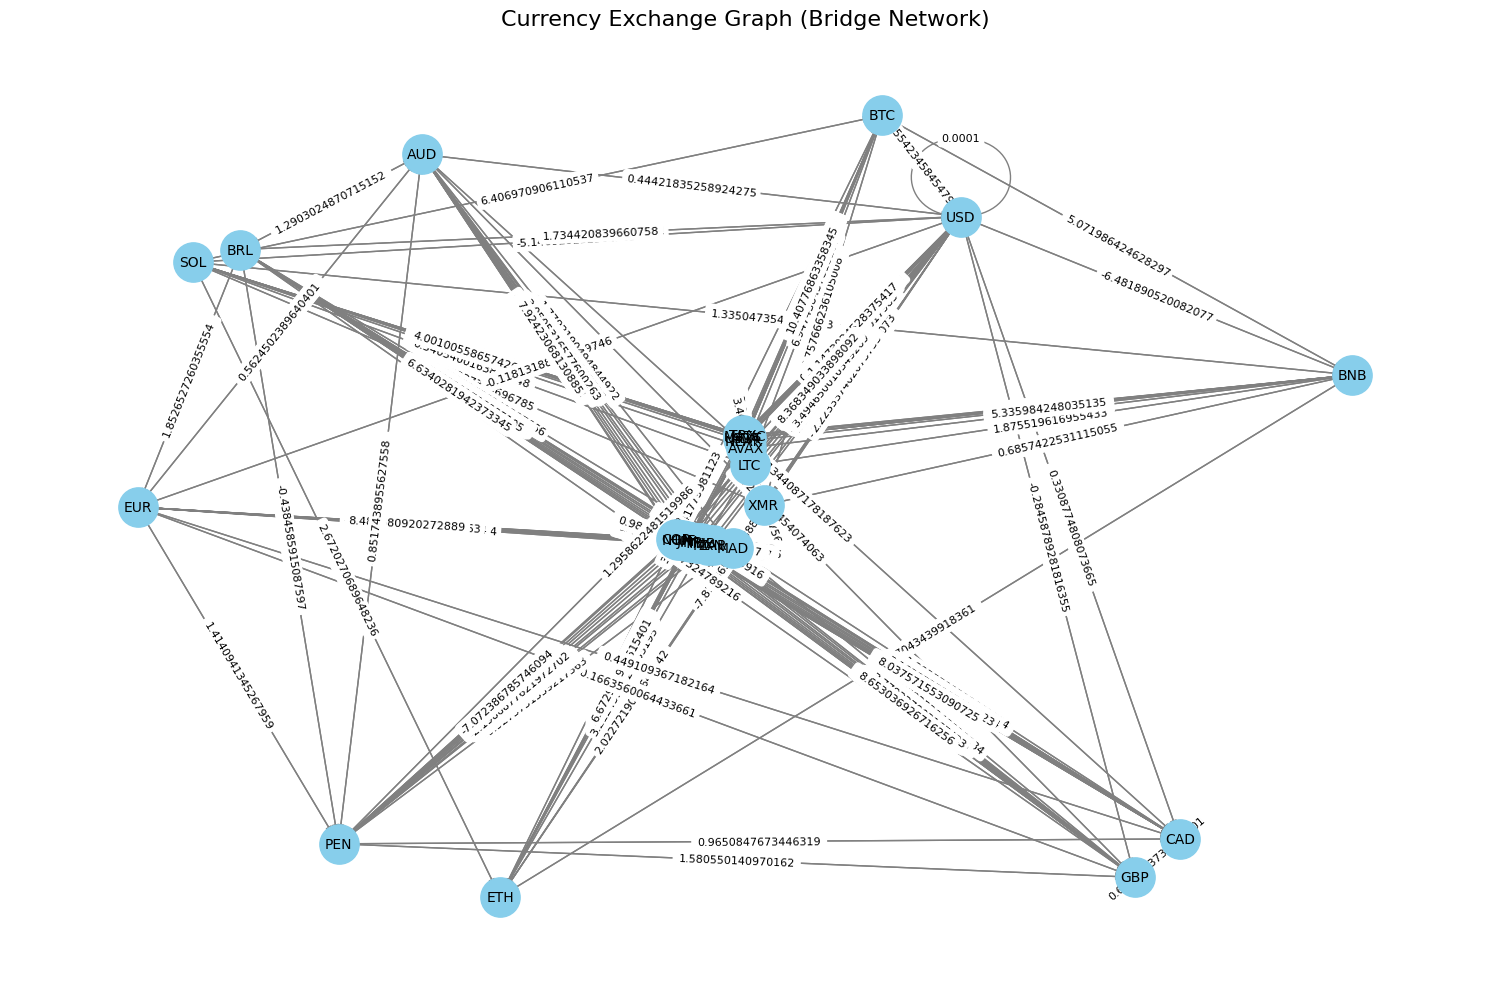

In [23]:
import matplotlib.pyplot as plt
import networkx as nx

# Draw the currency graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)  # use spring layout for better spacing
edge_labels = nx.get_edge_attributes(G, 'weight')

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

# Optionally draw weights on edges
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Currency Exchange Graph (Bridge Network)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()
